In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import stft, welch
from scipy.stats import kurtosis, skew
from scipy.fft import fft, fftfreq

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle, parallel_backend
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from joblib import Parallel, parallel_backend

In [4]:
# Function to compute time features
def compute_time_features(data, sample_rate):
    features = {}
    features['mean'] = np.mean(data)
    features['RMS'] = np.sqrt(np.mean(np.square(data)))
    features['StandardDeviation'] = np.std(data)
    features['ShapeFactor'] = np.sqrt(np.mean(np.square(data))) / np.mean(np.abs(data))
    features['SNR'] = np.mean(data) / np.std(data)
    features['THD'] = np.sqrt(np.sum(np.square(data[1:])) / np.square(data[0])) # Total Harmonic Distortion
    features['SINAD'] = np.mean(data) / np.sqrt(np.mean(np.square(data - np.mean(data))))
    features['PeakValure'] = np.max(np.abs(data))
    features['CrestFactor'] = np.max(np.abs(data)) / np.sqrt(np.mean(np.square(data)))
    features['ClearanceFactor'] = np.max(np.abs(data)) / np.mean(np.sqrt(np.abs(data)))
    features['ImpulseFactor'] = np.max(np.abs(data)) / np.mean(np.abs(data))
    return features

# Function to compute frequency features
def compute_frequency_features(data, sample_rate):
    freq_domain = np.abs(fft(data))
    freqs = fftfreq(len(data), 1 / sample_rate)
    features = {}
    features['MeanFrequency'] = np.mean(freq_domain)
    features['MedianFrequency'] = np.median(freq_domain)
    features['BandPower'] = np.sum(freq_domain ** 2)
    features['OccupiedBandwidth'] = np.sum(freq_domain > 0.05 * np.max(freq_domain))
    features['PowerBandwidth'] = np.sum(freq_domain > 0.5 * np.max(freq_domain))
    features['PeakAmplitude'] = np.max(freq_domain)
    features['PeakLocation'] = freqs[np.argmax(freq_domain)]
    return features

# Function to compute time-frequency features using STFT
def compute_time_freq_features(data, sample_rate):
    f, t, Zxx = stft( data, fs=sample_rate, nperseg=256)
    magnitude = np.abs(Zxx)

    features={}
    features['SpectralKurtosis'] = kurtosis(magnitude, axis=None)
    features['SpectralSkewness'] = skew(magnitude, axis=None)
    features['SpectralCrest'] = np.max(magnitude) / np.mean(magnitude)
    features['SpectralFlatness'] = np.exp(np.mean(np.log(magnitude))) / np.mean(magnitude)
    features['SpectralEntropy'] = -np.sum(magnitude * np.log2(magnitude), axis=None)
    features['SpectralCentroid'] = np.sum(f[:, np.newaxis] * magnitude, axis=0) / np.sum(magnitude, axis=0)
    features['SpectralSpread'] = np.sqrt(np.sum((f[:, np.newaxis] - features['SpectralCentroid'])**2 * magnitude, axis=0) / np.sum(magnitude, axis=0))
    features['SpectralRolloff'] = np.sum(magnitude, axis=0)[np.newaxis] * 0.85
    features['TFRidges'] = np.argmax(magnitude, axis=0)
    features['InstantaneousBandwidth'] = np.std(magnitude, axis=0)
    features['InstantaneousFrequency'] = np.mean(magnitude, axis=0)
    features['MeanEnvelopeEnergy'] = np.mean(np.abs(magnitude), axis=0)
    features['WaveletEntropy'] = -np.sum(np.square(magnitude) * np.log2(np.square(magnitude)), axis=None)
    return features

# Function to aggregate features
def aggregate_features(vector_data):
    aggregated_features = {}
    for key, vec in vector_data.items():
        aggregated_features[f'{key}_mean'] = np.mean(vec)
        aggregated_features[f'{key}_std'] = np.std(vec)
        aggregated_features[f'{key}_min'] = np.min(vec)
        aggregated_features[f'{key}_max'] = np.max(vec)
        aggregated_features[f'{key}_range'] = np.ptp(vec)
    return aggregated_features

# Function to normalize features
def normalize_features(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Main function to extract features from all CSV files in a folder
def extract_m_features(folder_path):
    feature_table = pd.DataFrame()
    sample_rate = 1428.57

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            data = np.loadtxt(file_path, delimiter=',')

            time_features = compute_time_features(data, sample_rate)
            frequency_features = compute_frequency_features(data, sample_rate)
            time_frequency_features = compute_time_freq_features(data, sample_rate)

            aggregated_time_frequency_features = aggregate_features(time_frequency_features)

            combined_features = {**time_features, **frequency_features, **aggregated_time_frequency_features}

            combined_feature_table = pd.DataFrame([combined_features])
            
            feature_table = pd.concat([feature_table, combined_feature_table], ignore_index=True)

    feature_table = feature_table.apply(normalize_features, axis=0)
    feature_table['HealthState'] = 2

    return feature_table

# Usage
folder_path = "D:\MT dataset\mcsadc-IM motor-rotorbarfailure-2023\mcsadc-IM-motor-rotorbarfailure-OG\processed_CSV\SC_abc_2BB"
BB2_feature_table = extract_m_features(folder_path)

<>:95: SyntaxWarning: invalid escape sequence '\M'
<>:95: SyntaxWarning: invalid escape sequence '\M'
C:\Users\daryl\AppData\Local\Temp\ipykernel_41552\3858881097.py:95: SyntaxWarning: invalid escape sequence '\M'
  folder_path = "D:\MT dataset\mcsadc-IM motor-rotorbarfailure-2023\mcsadc-IM-motor-rotorbarfailure-OG\processed_CSV\SC_abc_2BB"
C:\Users\daryl\AppData\Local\Temp\ipykernel_41552\3858881097.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  features['THD'] = np.sqrt(np.sum(np.square(data[1:])) / np.square(data[0])) # Total Harmonic Distortion
c:\Users\daryl\anaconda3\envs\thesis_3_12\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [5]:
combined_feature_table = pd.concat([healthy_feature_table, BB1_feature_table, BB2_feature_table], ignore_index=True)
X = combined_feature_table.drop(columns=['HealthState'])
y = combined_feature_table['HealthState']

In [6]:
# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Debug statement to print the normalized data
print('Normalized X data:')
print(X_normalized)

print('Y_numeric data:')
print(y)

# now 'X_normalized' contains the normalized features and 'y' contains the labels

Normalized X data:
[[ 1.24199002  1.40827779  1.40824697 ... -1.50097385 -1.50097385
          nan]
 [ 1.22559824  1.40935844  1.40933014 ... -1.50061066 -1.50061066
          nan]
 [ 1.19790983  1.49539046  1.49536673 ... -1.63901939 -1.63901939
          nan]
 ...
 [ 0.03519331 -1.00568613 -1.00555201 ...  0.82652624  0.82652624
          nan]
 [ 0.08539204 -1.00943859 -1.00930519 ...  0.82718438  0.82718438
          nan]
 [ 0.06860929 -1.01878551 -1.01865166 ...  0.831202    0.831202
          nan]]
Y_numeric data:
0      0
1      0
2      0
3      0
4      0
      ..
391    2
392    2
393    2
394    2
395    2
Name: HealthState, Length: 396, dtype: int64


c:\Users\daryl\anaconda3\envs\thesis_3_12\Lib\site-packages\sklearn\utils\extmath.py:1140: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\daryl\anaconda3\envs\thesis_3_12\Lib\site-packages\sklearn\utils\extmath.py:1145: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\daryl\anaconda3\envs\thesis_3_12\Lib\site-packages\sklearn\utils\extmath.py:1165: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [8]:
# Define data augmentation functions
def add_noise(data, noise_level=0.01):
    noise = noise_level * np.random.normal(size=data.shape)
    return data + noise

def scale(data, scaling_factor=1.1):
    return data * scaling_factor

def time_shift(data, shift_max=2):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift)

def augment_data(X, Y, augmentations=5):
    augmented_X, augmented_Y = [], []
    for _ in range(augmentations):
        for x, y in zip(X, Y):
            augmented_X.append(add_noise(x))
            augmented_X.append(scale(x))
            augmented_X.append(time_shift(x))
            augmented_Y.extend([y, y, y])
    return np.array(augmented_X), np.array(augmented_Y)

# Assuming X_normalized and y are already defined
# Augment the dataset
augmented_X, augmented_Y = augment_data(X_normalized, y)

# Combine original and augmented data
X_final = np.vstack((X_normalized, augmented_X))
y_final = np.hstack((y, augmented_Y))

# Shuffle the data
X_final, y_final = shuffle(X_final, y_final, random_state=42)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_final = imputer.fit_transform(X_final)

# Debug statement to print the normalized data
print('Final X data:')
print(X_final)

print('Final y:')
print(y_final)

Final X data:
[[ 1.2767604  -0.79540414 -0.79546495 ...  0.77566814  0.77566814
  -0.02874299]
 [ 1.05164546 -0.82112063 -0.82118235 ...  0.72687735  0.72687735
  -0.02874299]
 [ 0.01236476 -0.99241122 -0.99299116 ...  0.82896453  0.82425558
  -0.02874299]
 ...
 [ 1.21526997 -0.12988826 -0.13018128 ...  0.33166703  0.32195804
  -0.02874299]
 [-0.25784477 -0.25788358 -1.65267539 ...  0.44893503 -0.00728187
  -1.23794979]
 [-1.23689458 -0.13281627 -0.09316784 ...  0.0026737  -0.08587326
  -1.23698193]]
Final y:
[2 1 2 ... 0 0 0]


## Model: Support Vector Machine 
### Feature selection: Recursive Feature Elimination with Grid Search Cross-Validation 

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)


# Define the model and parameter grid for SVM
svm_model = SVC()
svm_param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Define the parameter grid for LinearSVC within RFECV
param_grid = {
    'estimator__C': [1, 10, 20, 25, 30, 40, 50]
}

# Create the GridSearchCV object for RFE feature selection
grid_search = GridSearchCV(
    estimator=RFECV(
        estimator=LinearSVC(max_iter=10000), 
        step=5, cv=5, scoring='accuracy', 
        n_jobs=-1, verbose=1,
        ),
        param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the RFECV model
with parallel_backend('threading'):
    grid_search.fit(X_train, y_train)

# Get the best RFECV estimator
best_rfecv = grid_search.best_estimator_

# Get the selected features for SVM    
selected_features_svm = best_rfecv.support_


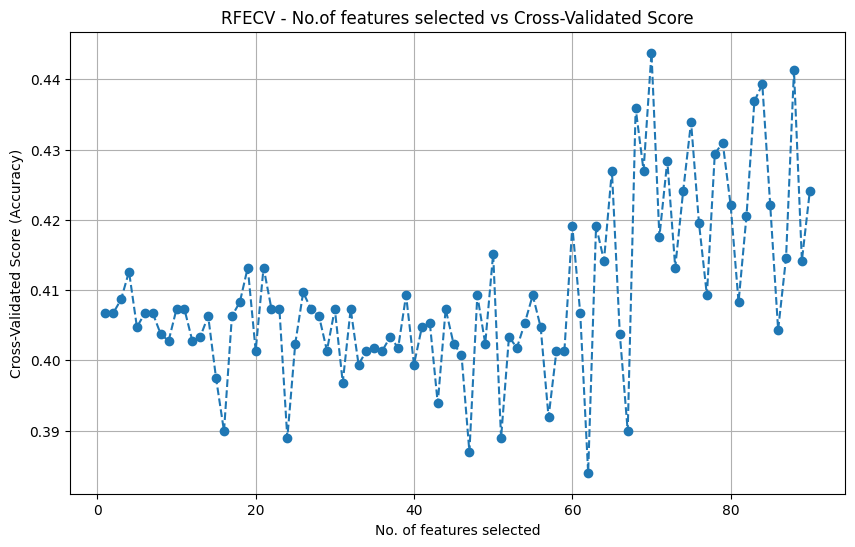

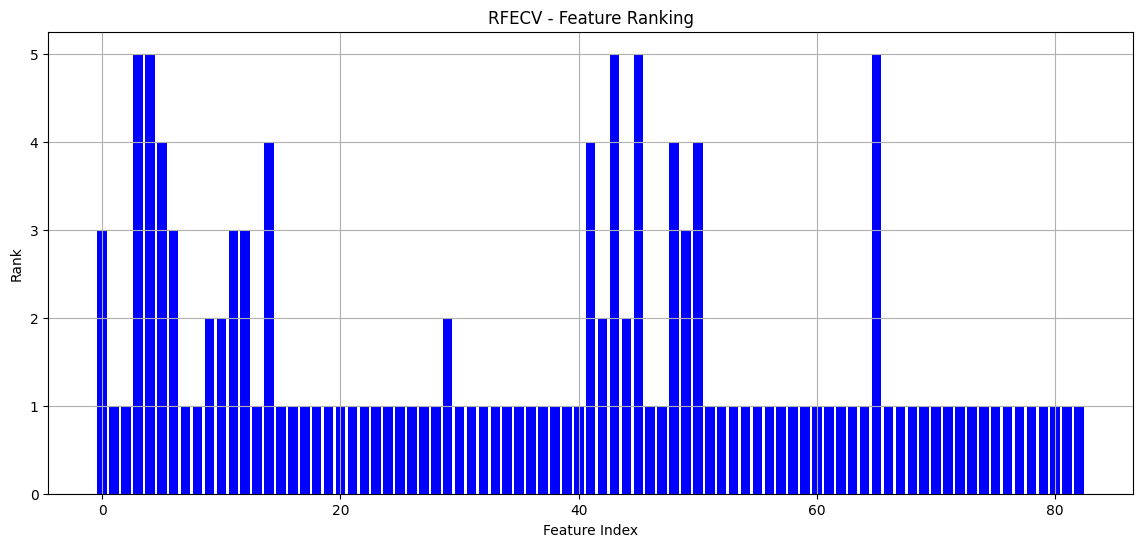

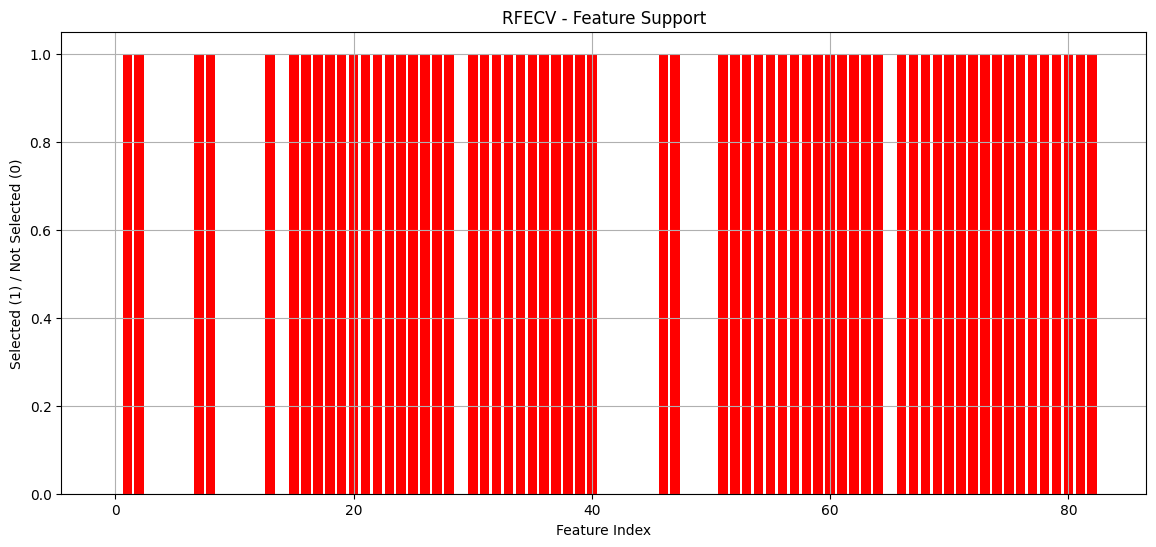

In [18]:


# Plot the number of features selected versus cross-validated score
plt.figure(figsize=(10, 6))
plt.title('RFECV - No.of features selected vs Cross-Validated Score')
plt.xlabel('No. of features selected')
plt.ylabel('Cross-Validated Score (Accuracy)')
plt.plot(range(1, len(best_rfecv.cv_results_["mean_test_score"]) + 1), best_rfecv.cv_results_["mean_test_score"], marker='o', linestyle='--')
plt.grid()
plt.show()

# Plot the ranking of features
plt.figure(figsize=(14, 6))
plt.title('RFECV - Feature Ranking')
plt.xlabel('Feature Index')
plt.ylabel('Rank')
plt.bar(range(X_train.shape[1]), best_rfecv.ranking_, color='b', align='center')
plt.grid()
plt.show()

# Plot the support of features
plt.figure(figsize=(14, 6))
plt.title('RFECV - Feature Support')
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.bar(range(X_train.shape[1]), best_rfecv.support_, color='r', align='center')
plt.grid()
plt.show()

### Linear RFECV without grid search

In [19]:

# Create the RFE (Recursive Feature Elimination) model with cross-validation for SVM with a linear kernel
linear_svm = LinearSVC(max_iter=10000, C=0.1, penalty='l1', dual=False)
# Adjusting step parameter to reduce iterations
rfecv = RFECV(estimator=linear_svm, step=5, cv=StratifiedKFold(5), scoring='accuracy', min_features_to_select=40, n_jobs=-1, verbose=2)

# Fit the RFECV model
with parallel_backend('threading'):
    rfecv.fit(X_train, y_train)

# Get the selected features for SVM    
selected_features_rfecv = rfecv.support_

num_select_feat = np.sum(selected_features_rfecv)
print(f"Number of selected features with linear rfecv: {num_select_feat}")

Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.


c:\Users\daryl\anaconda3\envs\thesis_3_12\Lib\site-packages\sklearn\utils\deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Fitting estimator with 78 features.
Fitting estimator with 78 features.
Fitting estimator with 78 features.
Fitting estimator with 78 features.
Fitting estimator with 73 features.
Fitting estimator with 73 features.
Fitting estimator with 73 features.
Fitting estimator with 68 features.
Fitting estimator with 78 features.
Fitting estimator with 73 features.
Fitting estimator with 68 features.
Fitting estimator with 63 features.
Fitting estimator with 68 features.
Fitting estimator with 68 features.
Fitting estimator with 58 features.
Fitting estimator with 63 features.
Fitting estimator with 73 features.
Fitting estimator with 63 features.
Fitting estimator with 58 features.
Fitting estimator with 53 features.
Fitting estimator with 63 features.
Fitting estimator with 48 features.
Fitting estimator with 58 features.
Fitting estimator with 53 features.
Fitting estimator with 68 features.
Fitting estimator with 58 features.
Fitting estimator with 43 features.
Fitting estimator with 53 fe

In [20]:
Lsvm_x_train = rfecv.transform(X_train)
Lsvm_x_test = rfecv.transform(X_test)

linear_svm.fit(Lsvm_x_train, y_train)


Lsvm_y_pred = linear_svm.predict(Lsvm_x_test)
Lsvm_accuracy = accuracy_score(y_test, Lsvm_y_pred)

print("Linear SVM selected features:", num_select_feat)
print("SVM test accuracy:", Lsvm_accuracy*100)

Linear SVM selected features: 53
SVM test accuracy: 41.08832807570978


In [10]:
# This is the result displaying of grid search rfecv
# Check the number of selected features
num_selected_features_svm = np.sum(selected_features_svm)
print(f"Number of selected features with optimized Linear SVC: {num_selected_features_svm}")

# Transform the training and test sets with the selected features
X_train_selected_svm = best_rfecv.transform(X_train)
X_test_selected_svm = best_rfecv.transform(X_test)


Number of selected features with optimized Linear SVC: 63


### Using Principal Component Analysis for feature selection

Number of features after PCA: 20


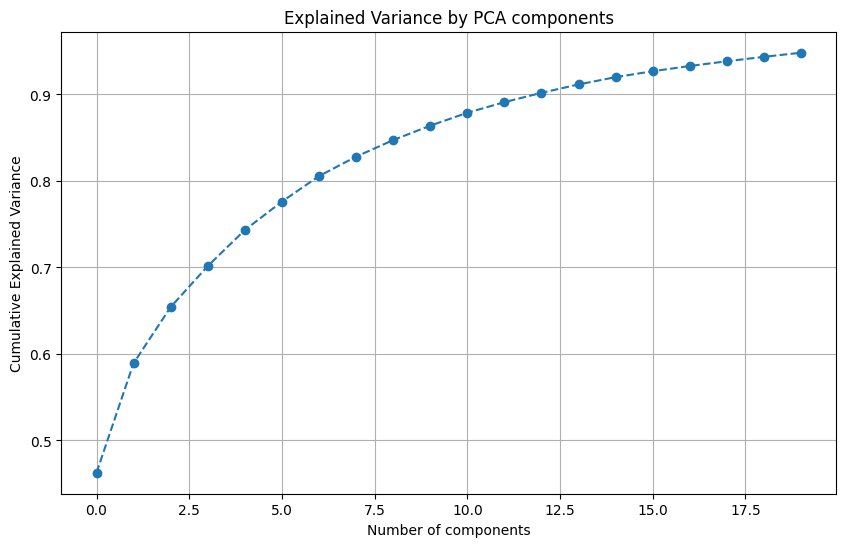

In [54]:
# Using PCA to reduce the number of features
n_components=20
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Print the number of features selected by PCA
print(f"Number of features after PCA: {n_components}")

# Plot the explained variance ratio to see the selection criteria
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by PCA components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


### Coarse and detailed Grid Search SVM 

In [11]:


# Create the pipeline with imputer and feature selection for SVM    # This is removed for now
# pipeline_svm = Pipeline([
    # ('imputer', SimpleImputer(strategy='mean')),
    # ('rfe', rfecv_svm),
# ])

# Coarse grid search to find the most promising hyperparameters
coarse_grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
coarse_grid_search_svm.fit(X_train_selected_svm, y_train)

# Narrow down the range for detailed search and USE THE BEST PARAMETERS from the coarse grid search for a more detailed search
best_params_svm = coarse_grid_search_svm.best_params_
detailed_param_grid_svm = {
    'kernel': [best_params_svm['kernel']],
    'C': [best_params_svm['C']/2, best_params_svm['C'], best_params_svm['C']*2],
    'gamma': [best_params_svm['gamma']]
}


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [17]:

# Perform a detailed grid search
detailed_grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=detailed_param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
detailed_grid_search_svm.fit(X_train_selected_svm, y_train)

# Get the best SVM model
svm_best_estimator = detailed_grid_search_svm.best_estimator_


Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [13]:
# Evaluate SVM model on the test set
y_pred_svm = svm_best_estimator.predict(X_test_selected_svm)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

print("SVM selected features:", selected_features_svm)
print("SVM test accuracy:", svm_accuracy*100)

SVM selected features: [False  True  True False False False False  True  True False False False
 False  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True False False False False False  True  True
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
SVM test accuracy: 99.76340694006309


# k-Nearest Neighbour Classification
## with SelectKBest feature selection

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 3/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=0.976 total time=   0.3s
[CV 5/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=0.976 total time=   0.3s
[CV 4/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=0.961 total time=   0.3s
[CV 2/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=0.968 total time=   0.3s
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=0.969 total time=   0.3s
[CV 3/5] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance;, score=0.978 total time=   0.3s
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance;, score=0.966 total time=   0.3s
[CV 2/5] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance;, score=0.968 total time=   0.3s
[CV 1/5] END knn__metric=euclidean, knn__n_neighbo

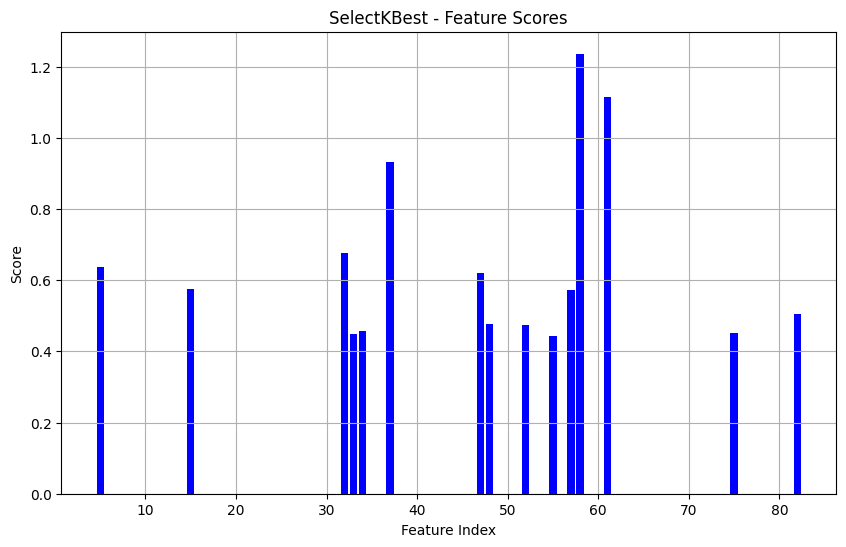

In [15]:
# Define the model and parameter grid for kNN
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create the SelectKBest feature selector, k value as 20
select_k_best = SelectKBest(score_func=f_classif, k=15)
# select_k_best.fit(X_train, y_train) , fitting the model outside leads to data leakage

# Define a pipeline
pipeline_knn = Pipeline([
    ('select_k_best', select_k_best),
    ('knn', knn_model)
])

# Perform grid search on the pipeline for kNN
grid_search_knn = GridSearchCV(estimator=pipeline_knn, param_grid=knn_param_grid, cv=5, n_jobs=-1, verbose=3)

# Fit the kNN model
with parallel_backend('threading'):
    grid_search_knn.fit(X_train, y_train)

# Get the best kNN estimator
knn_best_pipeline = grid_search_knn.best_estimator_

# Extract the SelectKBest from the best pipeline and get the selected feature scores
best_select_k_best = knn_best_pipeline.named_steps['select_k_best']
selected_features_indices = best_select_k_best.get_support(indices=True)
selected_scores = best_select_k_best.scores_[selected_features_indices]

# Plot the scores of the selected features
plt.figure(figsize=(10, 6))
plt.title('SelectKBest - Feature Scores')
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.bar(selected_features_indices, selected_scores, color='b', align='center')
plt.grid()
plt.show()


In [16]:
# Predict the test set labels using the best pipeline
y_pred_knn = knn_best_pipeline.predict(X_test)

# Calculate the kNN accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn) * 100

print("kNN selected features:", selected_features_indices)
print("kNN test accuracy:, {:.2f}".format(knn_accuracy))

kNN selected features: [ 5 15 32 33 34 37 47 48 52 55 57 58 61 75 82]
kNN test accuracy:, 98.58
